In [34]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
from scipy import stats


In [35]:
def gen_sp(length, sp_time, before, after):
    return np.concatenate((np.random.normal(*before, sp_time), np.random.normal(*after,length-sp_time))), np.arange(0,length)

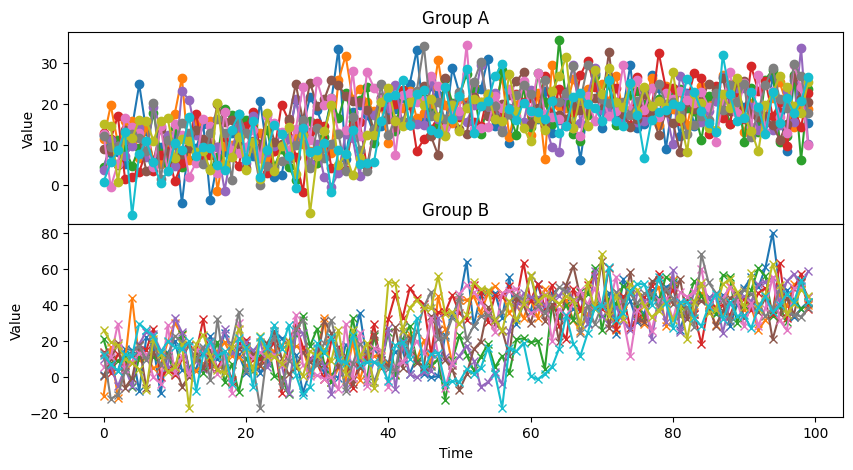

In [130]:
# group A
data = []
fig, ax = plt.subplots(2, 1, figsize=(10, 5))

# share x axis
fig.subplots_adjust(hspace=0)

ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Group A')

obs = []
nA = 10
for i in range(10):
    sp = np.random.randint(20,40)
    y, x = gen_sp(100, sp, (10,5), (20,5))
    ax[0].plot(x, y, 'o', linestyle='-', label=f'group A {i}')
    yA = y
    obs.append(yA)



# group B
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Value')
ax[1].set_title('Group B')
nB = 10
for i in range(10):
    sp = np.random.randint(40,70)
    y, x = gen_sp(100, sp, (10,10), (40,10))
    ax[1].plot(x, y, 'x', linestyle='-', label=f'group B {i}')
    yB = y
    obs.append(yB)

obs = np.array(obs).T

In [ ]:
group_id = [0]*nA + [1]*nB
    'group_id': [0,1]


In [140]:
X = np.array([x for _ in range(nA+nB)])
ind_id = list(range(nA+nB))


with pm.Model(coords={
    'ind_id': ind_id,
}) as SwitchPointModel:

    sigma = pm.HalfCauchy("sigma", beta=2, dims="ind_id")

    # draw a switchpoint from a uniform distribution for each individual
    switchpoint = pm.DiscreteUniform("switchpoint", lower=0, upper=100, dims="ind_id")

    # priors for the two groups
    mu1 = pm.HalfNormal("mu1", sigma=10, dims="ind_id")
    mu2 = pm.HalfNormal("mu2", sigma=10, dims="ind_id")
    
    
    diff = pm.Deterministic("diff", mu1 - mu2)

    # create a deterministic variable for the intercept
    intercept = pm.math.switch(switchpoint < X.T, mu1, mu2)

    obsA = pm.Normal("y", mu=intercept, sigma=sigma, observed=obs)

    trace = pm.sample()

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma, mu1, mu2]
>Metropolis: [switchpoint]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'switchpoint'}>,
        <Axes: title={'center': 'switchpoint'}>],
       [<Axes: title={'center': 'diff'}>,
        <Axes: title={'center': 'diff'}>]], dtype=object)

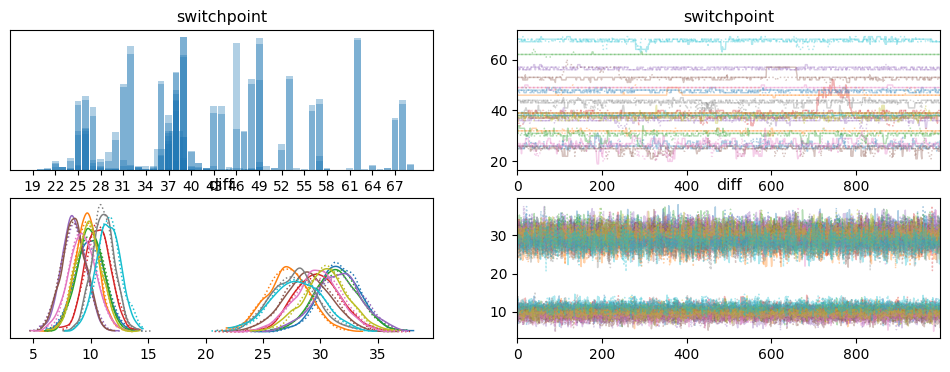

In [141]:
az.plot_trace(trace, var_names=["switchpoint", "diff"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

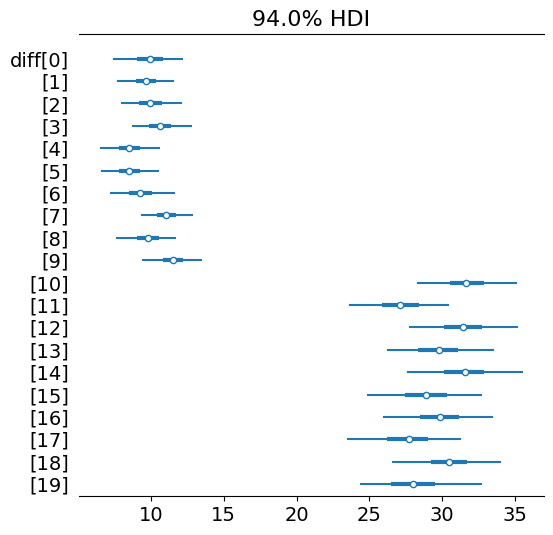

In [143]:
az.plot_forest(trace, var_names=["diff"], combined=True)

In [ ]:
with pm.Model(coords={
    'ind_id': ind_id,
}) as sp_model_half:

    sigma = pm.HalfCauchy("sigma", beta=2)

    switchpointA = pm.DiscreteUniform("switchpointA", lower=0, upper=100, dims=(2,))
    switchpointB = pm.DiscreteUniform("switchpointB", lower=0, upper=100, dims=(2,))

    switchpointDiff = pm.Deterministic("switchpointDiff", switchpointB - switchpointA)

    mu1A = pm.HalfNormal("mu1A", sigma=10)
    mu2A = pm.HalfNormal("mu2A", sigma=10)


    mu1B = pm.HalfNormal("mu1B", sigma=10)
    mu2B = pm.HalfNormal("mu2B", sigma=10)
    
    
    preSwitchDiff = pm.Deterministic("preSwitchDiff", mu1B - mu1A)
    postSwitchDiff = pm.Deterministic("postSwitchDiff", mu2B - mu2A)

    intercept = pm.math.switch(switchpointA < x, mu1A, mu2A)
    interceptB = pm.math.switch(switchpointB < x, mu1B, mu2B)

    

    obsA = pm.Normal("yA", mu=intercept, sigma=sigma, observed=yAs)
    obsB = pm.Normal("yB", mu=interceptB, sigma=sigma, observed=yBs)

    trace = pm.sample()
    # trace = pm.sample_prior_predictive()

In [ ]:
trace

array([[<Axes: title={'center': 'switchpointA'}>,
        <Axes: title={'center': 'switchpointA'}>],
       [<Axes: title={'center': 'switchpointB'}>,
        <Axes: title={'center': 'switchpointB'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu1A'}>,
        <Axes: title={'center': 'mu1A'}>],
       [<Axes: title={'center': 'mu2A'}>,
        <Axes: title={'center': 'mu2A'}>],
       [<Axes: title={'center': 'mu1B'}>,
        <Axes: title={'center': 'mu1B'}>],
       [<Axes: title={'center': 'mu2B'}>,
        <Axes: title={'center': 'mu2B'}>],
       [<Axes: title={'center': 'switchpointDiff'}>,
        <Axes: title={'center': 'switchpointDiff'}>],
       [<Axes: title={'center': 'preSwitchDiff'}>,
        <Axes: title={'center': 'preSwitchDiff'}>],
       [<Axes: title={'center': 'postSwitchDiff'}>,
        <Axes: title={'center': 'postSwitchDiff'}>]], dtype=object)

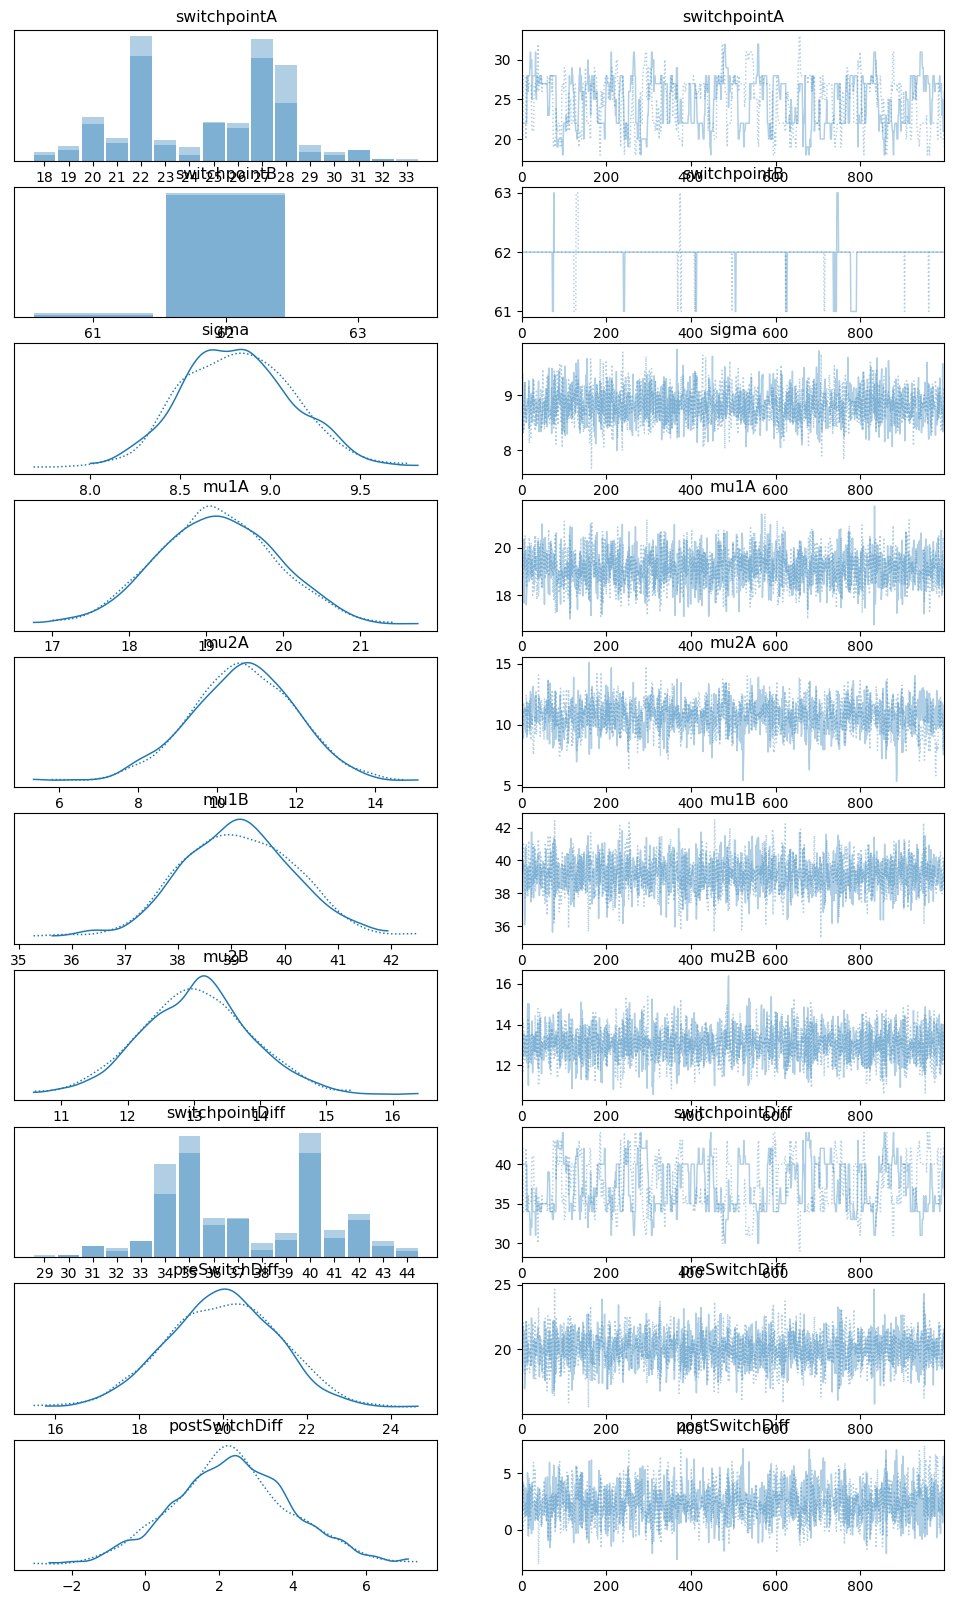

In [64]:
az.plot_trace(trace)

In [14]:
conversionRateA = 0.05
conversionRateB = 0.03

In [22]:
obsA = np.random.binomial(1, conversionRateA, 100)
obsB = np.random.binomial(1, conversionRateB, 100)

# contingency table

contingency = np.array([[obsA.sum(), (1-obsA).sum()], [obsB.sum(), (1-obsB).sum()]])

In [31]:
obsA

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
pd.DataFrame(contingency, index=['version A', 'version B'], columns=['converted', 'not converted'])

,converted,not converted
version A,5,95
version B,3,97


In [30]:
stats.chi2_contingency(contingency)

Chi2ContingencyResult(statistic=0.13020833333333334, pvalue=0.7182161295339857, dof=1, expected_freq=array([[ 4., 96.],
       [ 4., 96.]]))

In [17]:
with pm.Model() as model:
    pA = pm.Uniform('pA', 0, 1)
    pB = pm.Uniform('pB', 0, 1)
    
    delta = pm.Deterministic('delta', pA - pB)
    
    obsA = pm.Bernoulli('obsA', pA, observed=obsA)
    obsB = pm.Bernoulli('obsB', pB, observed=obsB)
    
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pA, pB]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


/home/laurinbrechter/.local/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'pA'}>, <Axes: title={'center': 'pA'}>],
       [<Axes: title={'center': 'pB'}>, <Axes: title={'center': 'pB'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>]], dtype=object)

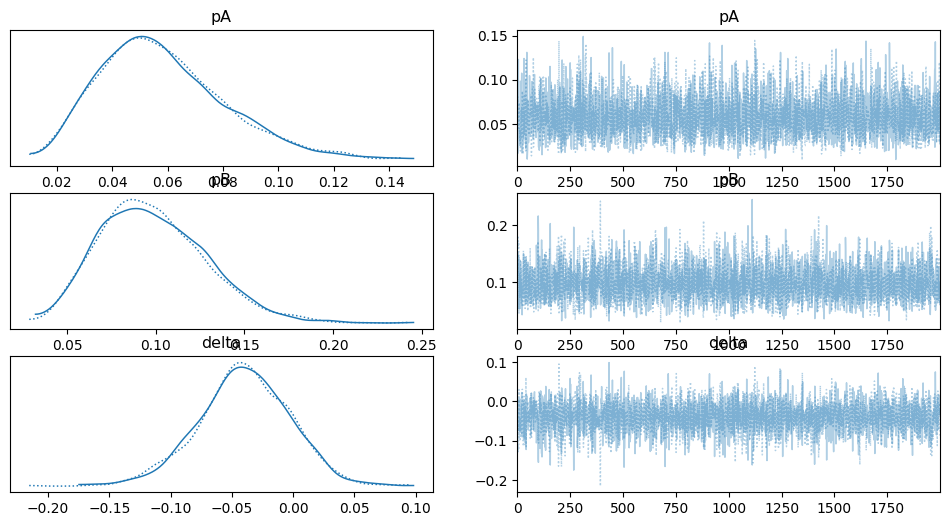

In [33]:
az.plot_trace(trace)